In [58]:
#DATA SIMULATION 
import numpy as np
import pandas as pd

# Simulating data
np.random.seed(39)
n_orders = 1000  # Number of orders
n_products = 50  # Number of products

# Create random data
order_ids = np.arange(1, n_orders + 1)
product_ids = np.random.randint(1, n_products + 1, size=n_orders)
inventory_levels = np.random.randint(100, 1000, size=n_orders)
delivery_routes = np.random.choice(['Route_A', 'Route_B', 'Route_C', 'Route_D'], size=n_orders)
delivery_times = np.random.uniform(1, 12, size=n_orders)  # Delivery time in hours
cost_per_delivery = np.random.uniform(50, 500, size=n_orders)  # Delivery costs
demand_forecast = np.random.randint(50, 1000, size=n_orders)
actual_sales = demand_forecast * np.random.uniform(0.8, 1.2, size=n_orders)

# Creating DataFrame
supply_chain_data = pd.DataFrame({
    'order_id': order_ids,
    'product_id': product_ids,
    'inventory_level': inventory_levels,
    'delivery_route': delivery_routes,
    'delivery_time': delivery_times,
    'cost_per_delivery': cost_per_delivery,
    'demand_forecast': demand_forecast,
    'actual_sales': actual_sales
})

# Overview of the simulated data
print(supply_chain_data.head())


   order_id  product_id  inventory_level delivery_route  delivery_time  \
0         1          10              663        Route_A       1.143227   
1         2          42              345        Route_B      11.567064   
2         3          42              664        Route_D       8.844295   
3         4           1              235        Route_C       3.567022   
4         5          21              771        Route_C       9.317968   

   cost_per_delivery  demand_forecast  actual_sales  
0         231.603875              585    674.945858  
1         277.936212              651    687.214615  
2         362.347071              985    880.850307  
3         471.277654              833    908.178368  
4         174.001464              201    232.830935  


In [59]:
supply_chain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           1000 non-null   int64  
 1   product_id         1000 non-null   int32  
 2   inventory_level    1000 non-null   int32  
 3   delivery_route     1000 non-null   object 
 4   delivery_time      1000 non-null   float64
 5   cost_per_delivery  1000 non-null   float64
 6   demand_forecast    1000 non-null   int32  
 7   actual_sales       1000 non-null   float64
dtypes: float64(3), int32(3), int64(1), object(1)
memory usage: 50.9+ KB


In [65]:
#EDA WE FIRST CHECK FOR MISSING VALUES, DUPLICATES ETC
#checking for missing values
supply_chain_data.isna().any(axis=1).sum()

np.int64(0)

In [61]:
#check for and drop any duplicates
supply_chain_data.duplicated().any().sum()

np.int64(0)

In [66]:
#Descriptive Statistics
supply_chain_data.describe()

,order_id,product_id,inventory_level,delivery_time,cost_per_delivery,demand_forecast,actual_sales,delivery_delay,demand_gap
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,511.687747,26.337945,559.280632,6.826769,271.850722,516.000000,566.384918,0.171994,50.384918
std,290.093671,14.243095,262.884691,3.249235,125.471796,284.503765,312.980291,3.249235,44.184515
min,1.000000,1.000000,100.000000,1.029934,50.400167,50.000000,52.223506,-5.624842,0.015186
25%,263.500000,14.000000,330.000000,4.199076,171.310698,254.250000,287.707129,-2.455699,13.770454
50%,506.500000,27.000000,571.500000,7.140652,262.196352,511.000000,558.029913,0.485876,37.404004
75%,762.750000,38.000000,788.500000,9.672541,381.441194,778.000000,855.083521,3.017765,77.887310
max,998.000000,50.000000,999.000000,11.984427,499.926906,999.000000,1187.926729,5.329651,189.926729


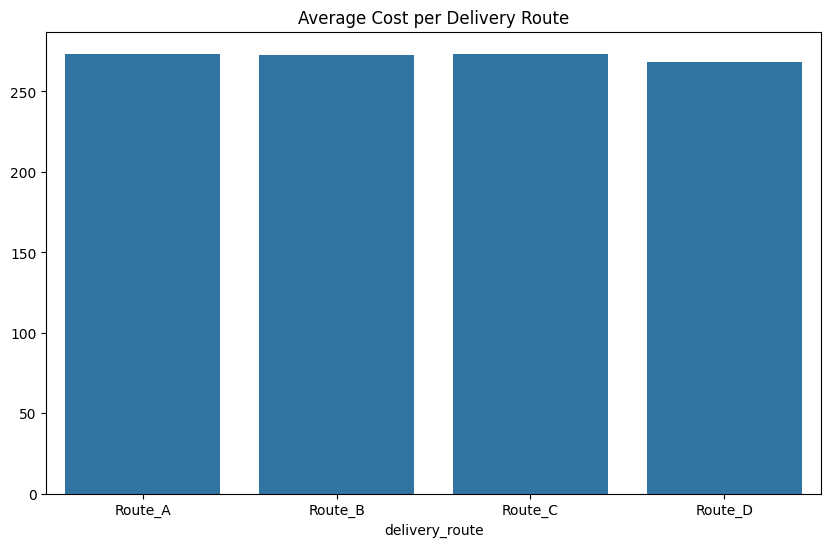

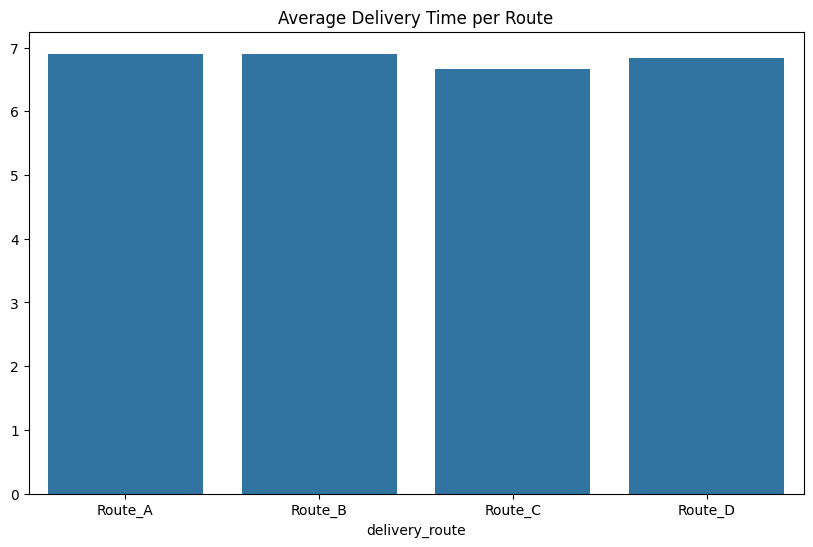

In [67]:
# Calculate average cost and delivery time by route
avg_cost_per_route = supply_chain_data.groupby('delivery_route')['cost_per_delivery'].mean()
avg_delivery_time_per_route = supply_chain_data.groupby('delivery_route')['delivery_time'].mean()

# Visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_cost_per_route.index, y=avg_cost_per_route.values)
plt.title("Average Cost per Delivery Route")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delivery_time_per_route.index, y=avg_delivery_time_per_route.values)
plt.title("Average Delivery Time per Route")
plt.show()



In [72]:

from scipy.optimize import linprog

# Define costs for each route
cost_per_route = np.array([273.48146708, 272.4171821, 273.10002654, 268.02567083])

# Define time constraints for each route
time_per_route = np.array([6.89229603, 6.9047451, 6.66124033, 6.82991605])

# Define total allowed time (b)
max_time_allowed = 25

# Constraints matrix (A_ub): time per route
A_ub = np.array([time_per_route])

# Constraints vector (b_ub): total time constraint
b_ub = np.array([max_time_allowed])

# Additional constraint: Ensure that at least one route is chosen (sum(x) >= 1)
A_eq = np.ones((1, len(cost_per_route)))  # Coefficients for x_1 + x_2 + x_3 + x_4
b_eq = np.array([1])  # At least one route must be selected

# Bounds for each variable: 0 <= x_i <= 1 (fraction of each route that can be chosen)
x_bounds = [(0, 1) for _ in range(len(cost_per_route))]

# Use the `highs` method for linear programming optimization
res = linprog(c=cost_per_route, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=x_bounds, method='highs')

# Show the optimization result
print("Optimal route assignment (0 means not used, 1 means used):", res.x)
print("Optimized cost:", res.fun)

# Calculate total time required for selected routes
total_time_used = np.dot(res.x, time_per_route)
print("Total time required for selected routes:", total_time_used)


Optimal route assignment (0 means not used, 1 means used): [0. 0. 0. 1.]
Optimized cost: 268.02567083
Total time required for selected routes: 6.82991605


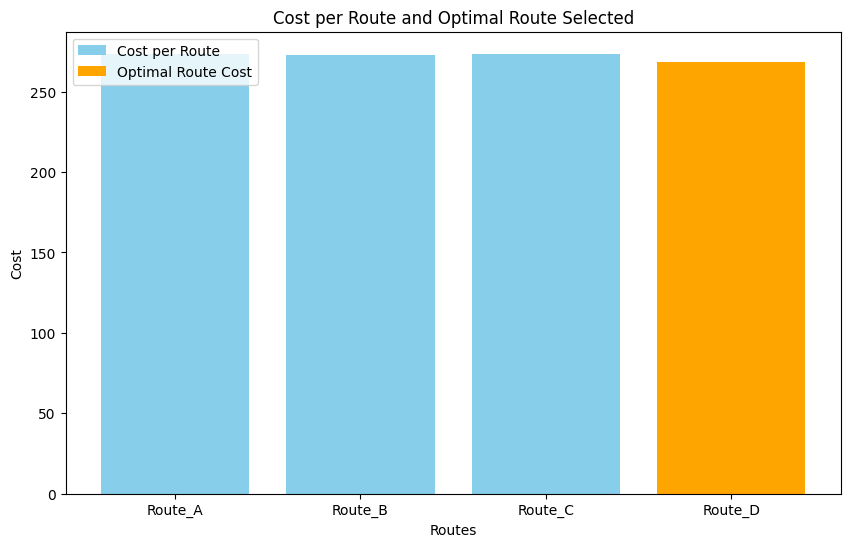

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Data
routes = ['Route_A', 'Route_B', 'Route_C', 'Route_D']
cost_per_route = np.array([273.48146708, 272.4171821, 273.10002654, 268.02567083])
optimal_route = res.x  # The result from the optimization (0 or 1)

# Bar plot of costs
plt.figure(figsize=(10,6))
plt.bar(routes, cost_per_route, color='skyblue', label='Cost per Route')
plt.bar(routes, optimal_route * cost_per_route, color='orange', label='Optimal Route Cost')

# Add labels and title
plt.xlabel('Routes')
plt.ylabel('Cost')
plt.title('Cost per Route and Optimal Route Selected')
plt.legend()
plt.show()


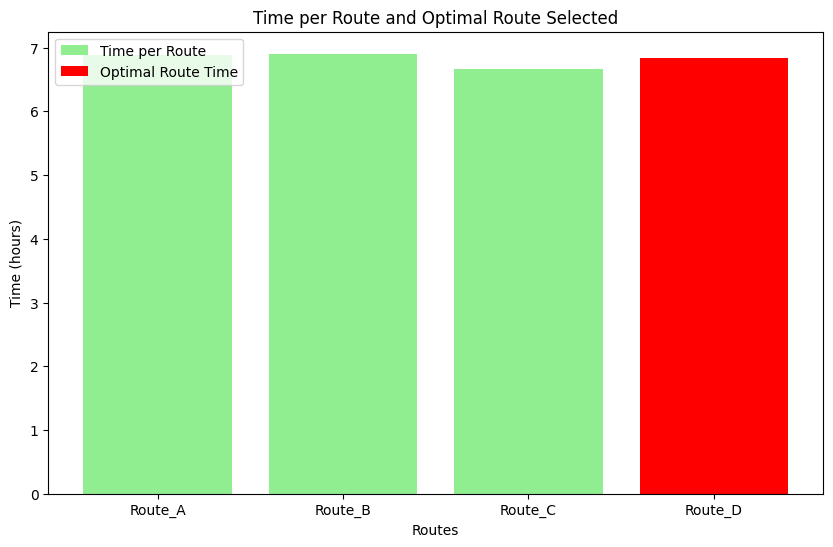

In [74]:
# Data for time
time_per_route = np.array([6.89229603, 6.9047451, 6.66124033, 6.82991605])

# Bar plot of times
plt.figure(figsize=(10,6))
plt.bar(routes, time_per_route, color='lightgreen', label='Time per Route')
plt.bar(routes, optimal_route * time_per_route, color='red', label='Optimal Route Time')

# Add labels and title
plt.xlabel('Routes')
plt.ylabel('Time (hours)')
plt.title('Time per Route and Optimal Route Selected')
plt.legend()
plt.show()


In [75]:
# Export data for Tableau/Power BI visualization
supply_chain_data.to_csv('supply_chain_data.csv', index=False)
